# Shared Task Submission

### Experimental Settings:

`Twitter word settings:`
* `window = 3 tokens `
* `embeddings -> twitter pre-trained embeddings, Godin`
* `dimensions = 400`
* `LSTM units = 100 -> 200 (Bi-LSTM)`

`Other settings:`
* `Epochs -> 150`
* `Batch size -> 500`
* `Opimizer -> Admax`
* `Seed 1337 for reproducibility`

In [1]:
experiment = 'notebook'

# os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cuda,floatX=float64"
import sys
sys.path += [new_path 
             for new_path in ['..', 
                              '../embeddings/twitter'] 
             if new_path not in sys.path]

import numpy as np
seed_number = 1337
np.random.seed(seed_number)  # for reproducibility

import pycrfsuite as crf
import matplotlib.pyplot as plt
import common.utilities as utils

from settings import *
from pycrfsuite import ItemSequence
from collections import Counter, defaultdict as ddict
from embeddings.twitter.word2vecReader import Word2Vec, Vocab
from sklearn.metrics import confusion_matrix, classification_report   
from sklearn.preprocessing import LabelBinarizer

from keras.models import Model
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalAveragePooling1D
from keras.optimizers import Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import RandomUniform

ImportError: No module named pycrfsuite

# Loading data

In [2]:
tweets_train, labels_train = utils.read_file_as_lists(TRAIN_PREPROC_URL)
tweets_dev,   labels_dev   = utils.read_file_as_lists(DEV_PREPROC_URL)
tweets_test,  labels_test  = utils.read_file_as_lists(TEST_PREPROC_URL)

tweets_train += tweets_dev
labels_train += labels_dev

vocabulary = list(set(utils.flatten(tweets_train + tweets_test)))

print("Vocabulary:", len(vocabulary))

Vocabulary: 19329


# Loading POS Tags

In [3]:
pos_tweets_train, postags_train = utils.read_file_as_lists(TRAIN_PREPROC_URL_POSTAG)
pos_tweets_dev,   postags_dev   = utils.read_file_as_lists(DEV_PREPROC_URL_POSTAG)
pos_tweets_test,  postags_test  = utils.read_file_as_lists(TEST_PREPROC_URL_POSTAG)

pos_tweets_train += pos_tweets_dev
postags_train += postags_dev

utils.sync_postags_and_tweets(tweets_train, pos_tweets_train, postags_train) 
utils.sync_postags_and_tweets(tweets_test, pos_tweets_test, postags_test)

# Loading Twitter embeddings

In [4]:
%%time 
w2v_model = Word2Vec.load_word2vec_format(W2V_TWITTER_EMB_GODIN, binary=True)
twitter_vb = {token:v.index for token,v in w2v_model.vocab.items()}

# Using only needed embeddings (faster this way)
twitter_index2word, twitter_embeddings = utils.pick_embeddings_by_indexes(vocabulary, w2v_model.syn0, twitter_vb)
twitter_index2word = [PAD_TOKEN, UNK_TOKEN] + twitter_index2word
twitter_word2index = ddict(lambda: twitter_index2word.index(UNK_TOKEN), {w:i for i,w in enumerate(twitter_index2word)})
twitter_embeddings = np.append(np.zeros((2,twitter_embeddings.shape[1])), twitter_embeddings, axis=0)

CPU times: user 1min 10s, sys: 2.34 s, total: 1min 12s
Wall time: 1min 12s


# Loading Gazetteers embeddings

In [5]:
gazetteers = utils.read_file_as_list_of_tuples(GAZET_EMB_ONE_CHECK)[0]
index2gaze, gaze_embeddings = zip(*[(data[0], data[1:]) for data in gazetteers])

index2gaze = [UNK_TOKEN, PAD_TOKEN] + list(index2gaze)
gaze2index = ddict(lambda: index2gaze.index(UNK_TOKEN), {g:i for i,g in enumerate(index2gaze)})
gaze_embeddings = np.append(np.zeros((2,6)), gaze_embeddings, axis=0)

# Encoding words and labels

In [6]:
window = 1

x_word_twitter_train = utils.build_x_matrix(window, [[twitter_word2index[token] for token in tweet] for tweet in tweets_train], twitter_word2index[PAD_TOKEN])
x_word_twitter_test  = utils.build_x_matrix(window, [[twitter_word2index[token] for token in tweet] for tweet in tweets_test], twitter_word2index[PAD_TOKEN])

index2label_cat = [
    'B-corporation',
    'B-creative-work',
    'B-group',
    'B-location',
    'B-person',
    'B-product',
    'I-corporation',
    'I-creative-work',
    'I-group',
    'I-location',
    'I-person',
    'I-product',
    'O'
]

y_cat_train, label2index_cat, _ = utils.vectorize_labels(labels_train, index2label_cat)

In [7]:
def map_to_binary(labels):
    return [['TRUE' if label != 'O' else 'FALSE' for label in lbls] for lbls in labels]
    
labels_seg_train = map_to_binary(labels_train)

index2label_seg = ['FALSE', 'TRUE']
label2index_seg = { l:i for i, l in enumerate(index2label_seg) }

lb = LabelBinarizer()
y_seg_train = lb.fit_transform(utils.flatten(labels_seg_train))

# Encoding POS tags

In [8]:
index2postag = [PAD_TOKEN] + list(set(utils.flatten(postags_train + postags_test)))
postag2index = {w:i for i,w in enumerate(index2postag)}

x_postag_train = utils.build_x_matrix(window, [[postag2index[token] for token in tweet] for tweet in postags_train], postag2index[PAD_TOKEN])
x_postag_test  = utils.build_x_matrix(window, [[postag2index[token] for token in tweet] for tweet in postags_test], postag2index[PAD_TOKEN])

# Encoding orthography

In [9]:
ortho_max_length = 20

index2ortho = ['x', 'c', 'C', 'n', 'p']
ortho2index = ddict(lambda: 0, {o:i for i,o in enumerate(index2ortho)})

x_ortho_twitter_train = pad_sequences(utils.encode_tokens(ortho2index, utils.flatten(utils.orthographic_mapping(tweets_train))), maxlen=ortho_max_length)
x_ortho_twitter_test  = pad_sequences(utils.encode_tokens(ortho2index, utils.flatten(utils.orthographic_mapping(tweets_test))), maxlen=ortho_max_length)

# Encoding gazetteers

In [10]:
encoded_gaze_train = [[gaze2index[token] for token in tweet] for tweet in tweets_train]
encoded_gaze_test  = [[gaze2index[token] for token in tweet] for tweet in tweets_test]

x_gaze_train = utils.build_x_matrix(window, encoded_gaze_train, gaze2index[PAD_TOKEN])
x_gaze_test  = utils.build_x_matrix(window, encoded_gaze_test, gaze2index[PAD_TOKEN])

# Neural Network -- Character Representation

In [11]:
def get_input_layer(shape, name):
    return Input(shape=shape, dtype='int32', name='{}_input'.format(name))

def pretrained_embedding_layer(embeddings, input_layer, input_len, name):
    embed_layer = Embedding(embeddings.shape[0], 
                           embeddings.shape[1], 
                           input_length=input_len, 
                           weights=[embeddings],
                           trainable=False,
                           name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.5, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer
    
    
def rand_uniform_embedding_layer(input_layer, input_dim, output_dim, input_len, name):
    uniform = RandomUniform(seed=seed_number, 
                            minval=-np.sqrt(3/output_dim),  # Suggested by
                            maxval= np.sqrt(3/output_dim))  # He et al (2015) 
    embed_layer = Embedding(input_dim=input_dim, 
                            output_dim=output_dim,
                            input_length=input_len, 
                            embeddings_initializer=uniform,
                            trainable=False,
                            name='{}_embed'.format(name))(input_layer)
    embed_layer = Dropout(0.5, name='{}_embed_dropout'.format(name))(embed_layer)
    return embed_layer

ortho_dim = 30
char_ortho_input = get_input_layer((ortho_max_length,), 'char_ortho')
char_ortho_embed = rand_uniform_embedding_layer(char_ortho_input, 
                                                len(index2ortho), 
                                                ortho_dim, 
                                                ortho_max_length, 
                                                'char_ortho')

### CNN Network

In [12]:
def get_char_cnn(embedded, name, filters=64, kernel_size=3, dense_units=32, convs=2):
    conv_net = embedded
    for _ in range(convs):
        conv_net = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(conv_net)
    conv_net = GlobalAveragePooling1D()(conv_net)
    conv_net = Dense(dense_units, activation='relu', name='{}_dense'.format(name))(conv_net)
    return conv_net

In [13]:
char_encoded = char_ortho_embed

char_encoded = get_char_cnn(char_encoded, 'char_encoded')
char_encoder = Model(inputs=[char_ortho_input], outputs=[char_encoded])
char_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
char_ortho_input (InputLayer (None, 20)                0         
_________________________________________________________________
char_ortho_embed (Embedding) (None, 20, 30)            150       
_________________________________________________________________
char_ortho_embed_dropout (Dr (None, 20, 30)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 64)            5824      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 64)            12352     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
char_encoded_dense (Dense)   (None, 32)                2080      
Total para

# Neural Network -- Word Representation

In [14]:
twitter_input = get_input_layer((window*2+1,), 'word_twitter')
twitter_embed = pretrained_embedding_layer(twitter_embeddings, 
                                           twitter_input, 
                                           window*2+1, 
                                           'word_twitter')

postag_dim = 100
postag_input = get_input_layer((window*2+1,), 'word_postag')
postag_embed = rand_uniform_embedding_layer(postag_input, 
                                            len(index2postag), 
                                            postag_dim,
                                            window*2+1, 
                                            'word_postag')

### BLSTM Network

In [15]:
word_encoded = concatenate([twitter_embed, postag_embed], axis=2)
word_encoded = Bidirectional(LSTM(100, 
                                  return_sequences=False, 
                                  dropout=0.2, 
                                  recurrent_dropout=0.2), 
                             name='word_encoded_blstm')(word_encoded)
word_encoded = Dropout(0.5, name='word_encoded_blstm_dropout')(word_encoded)
word_encoder = Model(inputs=[twitter_input, 
                             postag_input, 
                             ], outputs=[word_encoded])
word_encoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
word_twitter_input (InputLayer)  (None, 3)             0                                            
____________________________________________________________________________________________________
word_postag_input (InputLayer)   (None, 3)             0                                            
____________________________________________________________________________________________________
word_twitter_embed (Embedding)   (None, 3, 400)        6066400     word_twitter_input[0][0]         
____________________________________________________________________________________________________
word_postag_embed (Embedding)    (None, 3, 100)        10200       word_postag_input[0][0]          
___________________________________________________________________________________________

### Feed-Forward NN

In [16]:
gazetteer_input = get_input_layer((window * 2 + 1,), 'gazzetteer')
gazetteer_embed = pretrained_embedding_layer(gaze_embeddings, 
                                             gazetteer_input, 
                                             window*2+1, 
                                             'gazetteer')
gazetteer_dense = Dense(units=32, activation="relu", name='gazetteer_dense')(gazetteer_embed)
gazetteer_dense = Flatten()(gazetteer_embed)

### Final Concatenation

In [ ]:
network = concatenate([gazetteer_dense, char_encoded, word_encoded], name='concat_layer')
network = Dense(100, activation='relu', name='common_dense_layer') (network)

seg_output = Dense(1, activation='sigmoid', name='seg_output')(network)
cat_output = Dense(len(index2label_cat), activation='softmax', name='cat_output')(network)

word_inputs = [twitter_input, postag_input]
char_inputs = [char_ortho_input]
other_input = [gazetteer_input]

model = Model(inputs=other_input + char_inputs + word_inputs, 
              outputs=[seg_output, cat_output], 
              name='ne_model')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
char_ortho_input (InputLayer)    (None, 20)            0                                            
____________________________________________________________________________________________________
char_ortho_embed (Embedding)     (None, 20, 30)        150         char_ortho_input[0][0]           
____________________________________________________________________________________________________
word_twitter_input (InputLayer)  (None, 3)             0                                            
____________________________________________________________________________________________________
word_postag_input (InputLayer)   (None, 3)             0                                            
___________________________________________________________________________________________

In [ ]:
adamax = Adamax(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=adamax,
              loss={'seg_output': 'binary_crossentropy', 
                    'cat_output': 'categorical_crossentropy'},
              loss_weights={'seg_output': 1., 
                            'cat_output': 1.},
              metrics={'seg_output': [utils.fbeta_score, 'accuracy'],
                       'cat_output': [utils.fbeta_score, 'accuracy']})

early_stopping = EarlyStopping(patience=20, verbose=1)
# checkpointer = ModelCheckpoint(filepath='{}weights/{}.hdf5'.format(WEIGHTS_DIR, experiment),
#                                save_best_only=True, verbose=1)

train_word_values = [x_word_twitter_train, x_postag_train]
train_char_values = [x_ortho_twitter_train]
train_other_values = [x_gaze_train]

hist = model.fit(train_other_values + train_char_values + train_word_values, 
                 {'seg_output': y_seg_train, 'cat_output': y_cat_train}, 
                 batch_size=500, 
                 epochs=150, 
                 verbose=1, 
                 shuffle=True,
                 validation_split=0.2,
                 callbacks=[early_stopping])  # , checkpointer])

Train on 62770 samples, validate on 15693 samples
Epoch 1/150
62770/62770 [==============================] - 79s - loss: 0.7854 - seg_output_loss: 0.2334 - cat_output_loss: 0.5520 - seg_output_fbeta_score: nan - seg_output_acc: 0.9329 - cat_output_fbeta_score: nan - cat_output_acc: 0.9107 - val_loss: 0.6300 - val_seg_output_loss: 0.2230 - val_cat_output_loss: 0.4070 - val_seg_output_fbeta_score: nan - val_seg_output_acc: 0.9209 - val_cat_output_fbeta_score: 0.9207 - val_cat_output_acc: 0.9207

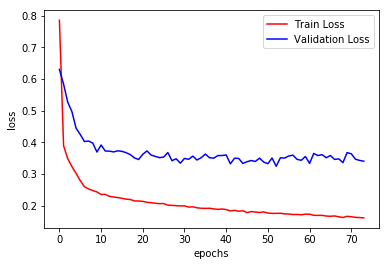

In [19]:
train_loss = hist.history["loss"]
val_loss = hist.history["val_loss"]
plt.plot(range(len(train_loss)), train_loss, color="red", label="Train Loss")
plt.plot(range(len(train_loss)), val_loss, color="blue", label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")
plt.show()

# Network Predictions

In [20]:
cat_model = Model(inputs=other_input + char_inputs + word_inputs, 
                  outputs=[cat_output], 
                  name='cat_model')

In [21]:
# Predicting test data
test_word_values = [x_word_twitter_test, x_postag_test]
test_char_values = [x_ortho_twitter_test]
test_other_values = [x_gaze_test]

prediction_probs = cat_model.predict(test_other_values + 
                                     test_char_values + 
                                     test_word_values, batch_size=500, verbose=1)
# Decoding predictions
decoded_predictions = utils.decode_predictions([np.argmax(p) for p in prediction_probs], index2label_cat)

23394/23394 [==============================] - 7s     

In [23]:
original_test_tweets,_ = utils.read_file_as_lists(TEST)

assert len(original_test_tweets) == len(tweets_test)
assert len(utils.flatten(original_test_tweets)) == len(utils.flatten(tweets_test))
assert len(utils.flatten(original_test_tweets)) == len(decoded_predictions)
    
utils.save_final_predictions('{}{}.network.tsv'.format(PREDICTIONS_DIR, experiment), 
                             original_test_tweets,
                             decoded_predictions)

#### Prediction insigths

In [24]:
# print("Classification Report\n")
# print(classification_report(utils.flatten(labels_test), decoded_predictions))
# print()
# print()
# print("Confusion Matrix\n")
# print(confusion_matrix(utils.flatten(labels_test), decoded_predictions))

# CRF-Suite Predictions

In [25]:
nn_model = Model(inputs=model.input, outputs=model.get_layer('common_dense_layer').output)

def get_xseq(model, matrix):
    xseq = [{'feat{}'.format(i):float(w) for i,w in enumerate(list(features))} 
            for features 
            in model.predict(matrix)]
    return ItemSequence(xseq)

xseq_train = get_xseq(nn_model, train_other_values + train_char_values + train_word_values)
yseq_train = utils.flatten(labels_train)

trainer = crf.Trainer(verbose=False)
trainer.append(xseq_train, yseq_train)
trainer.set_params({
    'c1': 1.0,                           # L1 penalty
    'c2': 1e-3,                          # L2 penalty
    'max_iterations': 100,               # stop earlier
    'feature.possible_transitions': True # possible transitions, but not observed
})
trainer.train('{}.pycrfsuite'.format(experiment))
trainer.logparser.last_iteration

tagger = crf.Tagger()
tagger.open('{}.pycrfsuite'.format(experiment))

# Predicting test data
decoded_predictions = tagger.tag(get_xseq(nn_model, 
                                          test_other_values + 
                                          test_char_values + 
                                          test_word_values))

# Saving predictions
utils.save_final_predictions('{}{}.crfsuite.tsv'.format(PREDICTIONS_DIR, experiment), 
                             original_test_tweets,
                             decoded_predictions)

#### Prediction insigths

In [26]:
# print("Classification Report\n")
# print(classification_report(utils.flatten(labels_test), decoded_predictions))
# print()
# print()
# print("Confusion Matrix\n")
# print(confusion_matrix(utils.flatten(labels_test), decoded_predictions))

In [27]:
from collections import Counter
info = tagger.info()

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(info.transitions).most_common(15))

print("\nTop unlikely transitions:")
print_transitions(Counter(info.transitions).most_common()[-15:])

Top likely transitions:
B-corporation -> I-corporation 7.338433
B-product -> I-product 6.962915
I-corporation -> I-corporation 6.661376
I-product -> I-product 5.887426
B-group -> I-group 5.827884
B-location -> I-location 5.294125
I-group -> I-group 5.057174
B-person -> I-person 4.787393
I-location -> I-location 4.171761
B-creative-work -> I-creative-work 3.858833
I-person -> I-person 3.821866
I-creative-work -> I-creative-work 2.245630
O      -> B-person 1.845740
B-corporation -> B-location 1.463694
O      -> B-product 1.311561

Top unlikely transitions:
B-corporation -> I-creative-work -1.019343
I-person -> I-creative-work -1.209857
I-location -> I-creative-work -1.265161
I-creative-work -> I-person -1.340210
I-group -> I-creative-work -1.375810
I-product -> I-creative-work -1.469447
B-location -> I-creative-work -1.632523
B-group -> B-group -2.043017
B-person -> I-creative-work -2.418775
O      -> I-product -2.863586
O      -> I-corporation -3.536680
O      -> I-location -3.560575
O 